In [1]:
import numpy as np
import bayesflow as bf
import seaborn as sns

INFO:bayesflow:Using backend 'tensorflow'


In [2]:
from ssms.basic_simulators.simulator import simulator as ssm_sim

In [3]:
def priors(rng=None):

    if rng is None:
        rng = np.random.default_rng()

    drift = rng.gamma(2, 0.8)
    threshold = rng.gamma(10, 0.2)
    bias = rng.beta(2, 2) * threshold
    ndt = rng.gamma(1.5, 0.2)

    return {'v': drift, 'a': threshold, 'z': bias, 't': ndt}

def batched_priors(rng=None, n_obs=1000):

    if rng is None:
        rng = np.random.default_rng()

    drift = rng.gamma(2, 0.8, size=n_obs)
    threshold = rng.gamma(10, 0.2, size=n_obs)
    bias = rng.beta(2, 2, size=n_obs) * threshold
    ndt = rng.gamma(1.5, 0.2, size=n_obs)

    return {'v': drift, 'a': threshold, 'z': bias, 't': ndt}

In [4]:
theta = priors()
theta

{'v': 6.475588356094235,
 'a': 1.642889728885779,
 'z': 0.7187549991031318,
 't': 0.3138402485093887}

In [11]:
def ddm_simulator(
        v=None, a=None, z=None, t=None,
        n_samples: int = 1
):
    
    ddm_sim = ssm_sim(model="ddm", theta=dict(v=v, a=a, z=z, t=t), n_samples=n_samples)

    rts = ddm_sim['rts'].astype(np.float32)
    choices = ddm_sim['choices'].astype(np.float32)

    return dict(rts=rts, choices=choices)

In [12]:
simulator = bf.make_simulator([priors, ddm_simulator])

In [13]:
draws = simulator.sample(batch_size=2)

In [14]:
print(draws['v'].shape)
print(draws['t'].shape)
print(draws['rts'].shape)
print(draws['choices'].shape)

(2, 1)
(2, 1)
(2, 1, 1)
(2, 1, 1)


In [ ]:
prior_samples = simulator.simulators[0].sample(500)
prior_samples

{'v': array([0.51759544, 0.74303581, 0.60389691, 0.65267291, 2.42690506,
        1.34354757, 1.0392454 , 1.39805571, 2.8671642 , 1.37627648,
        2.33745864, 0.23158824, 0.49066307, 1.16539342, 1.28423633,
        1.05139821, 0.98101812, 0.61732177, 0.77279605, 0.64048138,
        0.48264198, 2.89130237, 4.00913718, 1.09858227, 0.43016325,
        1.12525062, 1.87888846, 1.30862759, 0.15074388, 0.55945269,
        0.852818  , 1.76137237, 1.62944081, 0.88822685, 1.44711499,
        6.53224408, 0.16857569, 0.77594164, 1.81633133, 2.03800806,
        2.95054472, 0.9745739 , 1.58598553, 2.60030142, 1.67028684,
        2.08815141, 1.15471299, 2.94903739, 0.99745789, 2.87580502,
        2.56091957, 0.76068038, 1.005717  , 2.09288039, 0.95074452,
        0.86370375, 0.29039332, 0.64102395, 1.47244223, 0.7679357 ,
        1.1211701 , 0.68542721, 1.5329014 , 0.88677743, 0.71975754,
        0.58995769, 1.09146249, 0.47815328, 1.43360493, 1.12836476,
        0.71293979, 2.26480855, 2.8766583 ,

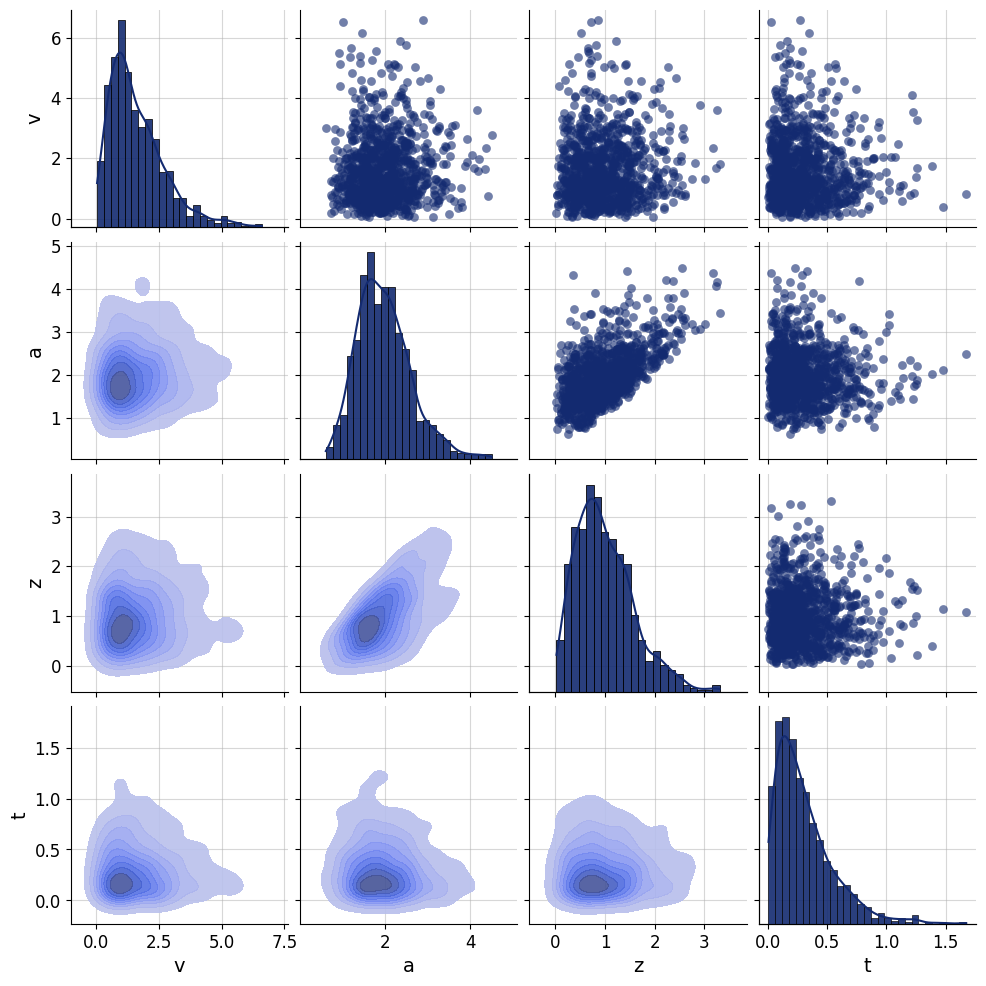

In [22]:
prior_grid = bf.diagnostics.plots.pairs_samples(
    samples=prior_samples, variable_keys=['v', 'a', 'z', 't']
)

In [23]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype('float64', 'float32')
    .concatenate(['v', 'a', 'z', 't'], into="inference_variables")
    .concatenate(['rts', 'choices'], into="summary_variables")
)

In [24]:
adapter

Adapter([0: ConvertDType -> 1: Concatenate(['v', 'a', 'z', 't'] -> 'inference_variables') -> 2: Concatenate(['rts', 'choices'] -> 'summary_variables')])

In [27]:
adapted_sims = adapter(simulator.sample(10))

In [28]:
print(adapted_sims['summary_variables'].shape)
print(adapted_sims['inference_variables'].shape)

(10, 1, 2)
(10, 4)


In [31]:
summary_net = bf.networks.SetTransformer(summary_dim=32)

In [32]:
inference_net = bf.networks.FlowMatching()

In [33]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=inference_net
)

In [35]:
%%time 
_ = workflow.simulate(32)

CPU times: total: 31.2 ms
Wall time: 34.7 ms


In [37]:
training_data = workflow.simulate(10000)
validation_data = workflow.simulate(500)

In [38]:
history = workflow.fit_offline(
    data=training_data,
    epochs=200,
    batch_size=64,
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
C:\Users\Gerald Wong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\ops\nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (64, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/200


C:\Users\Gerald Wong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\ops\nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\Gerald Wong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\ops\nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 3.5172 - loss/inference_loss: 3.5172 - val_loss: 1.1201 - val_loss/inference_loss: 1.1201
Epoch 2/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.2448 - loss/inference_loss: 1.2448 - val_loss: 1.1558 - val_loss/inference_loss: 1.1558
Epoch 3/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.0866 - loss/inference_loss: 1.0866 - val_loss: 0.9659 - val_loss/inference_loss: 0.9659
Epoch 4/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.0049 - loss/inference_loss: 1.0049 - val_loss: 0.9672 - val_loss/inference_loss: 0.9672
Epoch 5/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.9976 - loss/inference_loss: 0.9976 - val_loss: 1.0187 - val_loss/inference_loss: 1.0187
Epoch 6/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.9748 - loss/inference_loss: 0.9748 - val_loss: 0.9931 - val_loss/inference_loss: 0.9931
Epoch 7/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.9660 - loss/inference_loss: 0.9660 

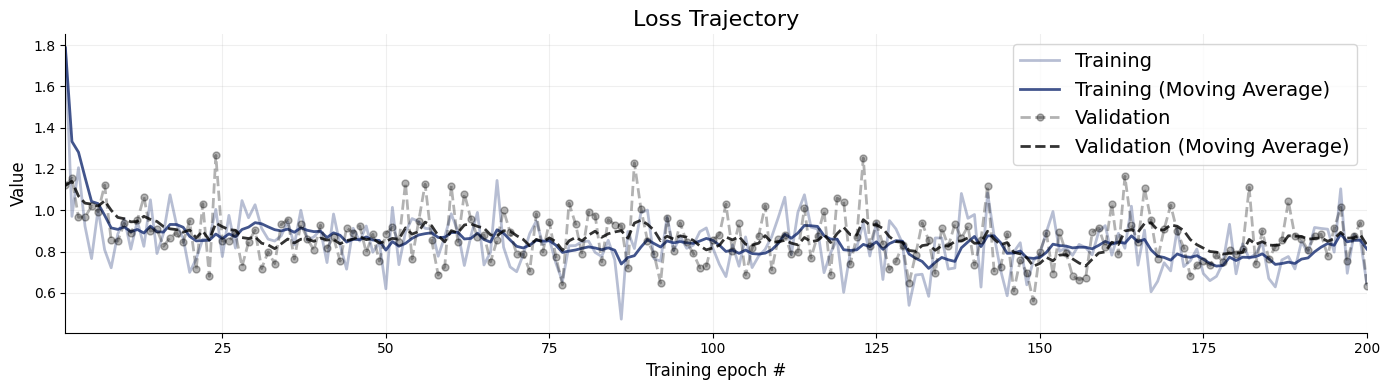

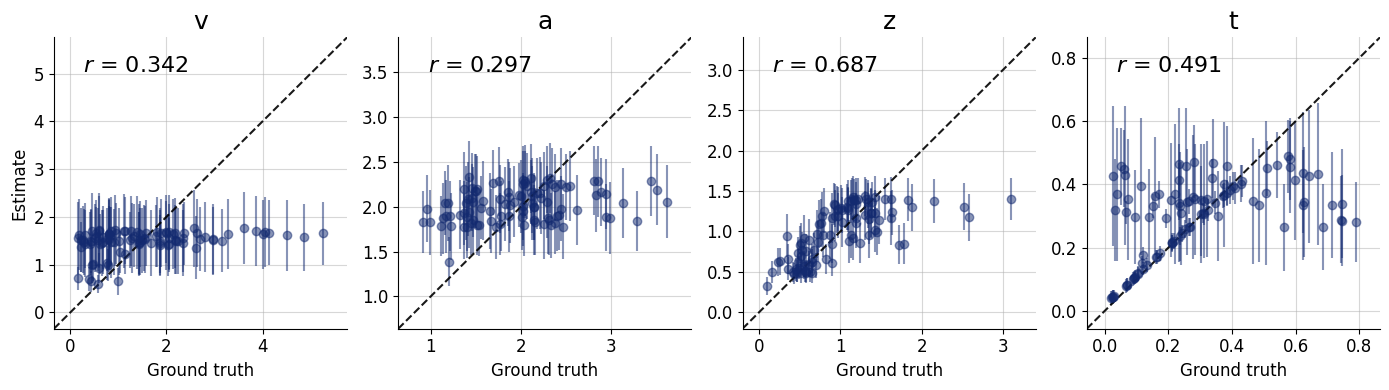

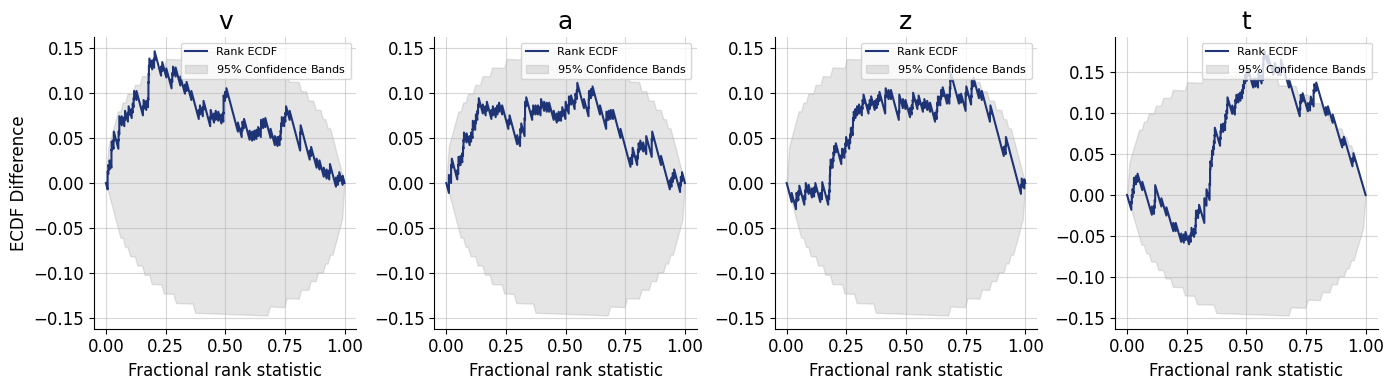

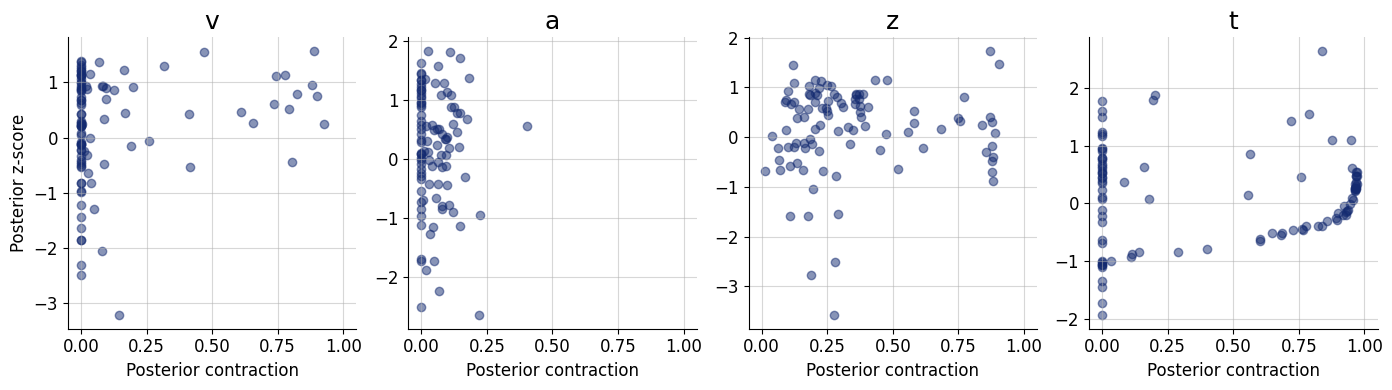

In [45]:
figures = workflow.plot_default_diagnostics(
    test_data=100,
    loss_kwargs={"figsize": (14, 4), "label_fontsize": 12},
    recovery_kwargs={"figsize": (14, 4), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (14, 4), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (14, 4), "label_fontsize": 12}    
)